In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 10})
import matplotlib.cm as cm
import seaborn as sns

import pickle as pkl

exec(open("./diagnostics_header.py").read())
import diagnostics_ops as diops
import diagnostics_vars as divars

# -----------------------------------------------------------------

# linestyles list from https://matplotlib.org/gallery/lines_bars_and_markers/linestyles.html
linestyles = [('solid',               (0, ())),
     #('loosely dotted',      (0, (1, 10))),
     #('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     #('loosely dashed',      (0, (5, 10))),
     #('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     #('loosely dashdotted',  (0, (3, 10, 1, 10))),
     #('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     #('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     #('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('solid',               (0, ()))]

In [2]:
save = False
dpi=300

# problem parameters
mach_no = 10
GM1 = 0.7692307692307692
x1max = 0.62              # maximum value of X1
inflow = -0.01            # radial velocity at L1
inflow_dens = 4.0         # density at L1
inflow_phi = 0.05         # angular half-size of the L1 zone
                          # if -n, L1 diameter set to n times thermal scale height
Porb = 2.*np.pi
    
inflow_mdot = -np.pi * (x1max*inflow_phi)**2 * inflow_dens * inflow

# time of start of the steady state
tstart_steady = 2.*np.pi * 34.

# time limits of accretion states
accretion_state_times = {'A':[34.,39.], 'B':[39., 45.6]}

def state2title (acc_state):
    if acc_state == None or acc_state == 'None':
        return 'steady'
    else:
        return 'state%s' % acc_state

frames_to_avg = int(2. * max(1, int(2.*np.pi/0.3)))

**General / qualitative review of the snapshots**

In [3]:
data_pathstem = '/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/'
dataset_pathstem = data_pathstem + 'R5_dfloor1e-6_vfloorRho1e-5/'

#snapshot_paths = {'A':(dataset_pathstem + 'mhdLoops_strat.out2.00345.athdf'), 'B':(dataset_pathstem + 'mhdLoops_strat.out2.00397.athdf'), 'C':(dataset_pathstem + 'mhdLoops_strat.out2.00450.athdf'), 'D':(dataset_pathstem + 'mhdLoops_strat.out2.00523.athdf'), 'E':(dataset_pathstem + 'mhdLoops_strat.out2.00586.athdf'), 'None':(dataset_pathstem + 'mhdLoops_strat.out2.00881.athdf')}
snapshot_paths = {'A':(dataset_pathstem + 'snapshots/mhdLoops_strat.out2.00775.athdf'), 'B':(dataset_pathstem + 'snapshots/mhdLoops_strat.out2.00908.athdf'), 'None':(dataset_pathstem + 'snapshots/mhdLoops_strat.out2.00839.athdf')}
snapshot_path = snapshot_paths['None']

output_path = '/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/Paper1/figures/toSend/Mach10/'

In [4]:
# kinetic helicity
from athena_read import athdf
from scipy.ndimage.filters import convolve

def signed_logscale (arr0):
    arr = np.where(np.abs(arr0) < 1., 0., np.nan)
    arr = np.where(arr0 >= 1., np.log10(arr0), arr)
    arr = np.where(arr0 <= -1., -np.log10(-arr0), arr)
    return arr

def prune (arr, vmin, vmax, val):
    arr = np.where(arr < vmin, -val, arr)
    arr = np.where(arr > vmax, val, arr)
    return arr

# transform sim velocities to account for frame rotation
def toInertial (r, theta, phi, vel1, vel2, vel3):
    GM = 0.7692307692307692
    def SQR (x): return x*x
    # transform to cylindrical coordinates
    r_cyl = r * np.sin(theta)
    # move to the barycenter system of coordinates
    r_bary = np.sqrt(SQR(r_cyl) + SQR(1.-GM) - 2.*r_cyl*(1.-GM)*np.cos(phi))
    phi_bary = np.arcsin(r_cyl*np.sin(phi)/r_bary)
    phi_bary = np.where(r_cyl*np.cos(phi) < (1.-GM), np.pi - phi_bary, phi_bary)
    # useful angle for coordinate transformations
    sin_alpha = np.sin(phi - phi_bary + 0.5*np.pi)
    cos_alpha = np.cos(phi - phi_bary + 0.5*np.pi)
    
    # rotating frame speed
    Mphi_bary = 1.0 * r_bary

    # move back to the LAB coordinates
    dMr = Mphi_bary * cos_alpha
    dMphi = Mphi_bary * sin_alpha
    
    #update momenta
    vel1 += dMr * np.sin(theta)
    vel2 += dMr * np.cos(theta)
    vel3 += dMphi
    
    return vel1, vel2, vel3

def kineticHelicity (athdf_filename, logscale=True):

    data = athdf(athdf_filename)
    time = data['Time']
    
    print(' -- t = %.2f sim.u.' % time, flush=True)

    r, theta, phi = data['x1v'], data['x2v'], data['x3v']
    rm, tm, pm = np.meshgrid(r, theta, phi, indexing='ij')
    dr = r[1:] - r[:-1]
    dtheta = theta[1:] - theta[:-1]
    dphi = phi[1:] - phi[:-1]
    drm, dtm, dpm = np.meshgrid(dr, dtheta, dphi, indexing='ij')
    ravg = 0.5 * (r[1:] + r[:-1])
    tavg = 0.5 * (theta[1:] + theta[:-1])
    pavg = 0.5 * (phi[1:] + phi[:-1])
    ravgm, tavgm, pavgm = np.meshgrid(ravg, tavg, pavg, indexing='ij')
    dV = ravgm**2 * np.sin(tavgm) * drm*dtm*dpm
    del drm, dtm, dpm

    vel1, vel2, vel3 = data['vel1'], data['vel2'], data['vel3']
    # account for frame rotation
    vel1, vel2, vel3 = toInertial(r, theta, phi, vel1, vel2, vel3)
    # ensure indices order [r, theta, phi]
    vel1 = np.transpose(vel1, (2,1,0))
    vel2 = np.transpose(vel2, (2,1,0))
    vel3 = np.transpose(vel3, (2,1,0))
    # average to match dimensions (n-1,n-1,n-1)
    vel1avg = convolve(vel1, np.ones([2,2,2]) * (0.5**3), mode='constant', cval=np.nan)[:-1,:-1,:-1]
    vel2avg = convolve(vel2, np.ones([2,2,2]) * (0.5**3), mode='constant', cval=np.nan)[:-1,:-1,:-1]
    vel3avg = convolve(vel3, np.ones([2,2,2]) * (0.5**3), mode='constant', cval=np.nan)[:-1,:-1,:-1]

    del data

    # -------------------------------------------------

    # nabla x vel

    # - component r
    vphi_sint = vel3 * np.sin(tm)
    dtheta_vphi_sint = (vphi_sint[:,1:,:] - vphi_sint[:,:-1,:]) / (np.tile(dtheta, [len(r), len(phi),1]).transpose(0,2,1))
    # average to match dimensions (n-1,n-1,n-1)
    dtheta_vphi_sint = 0.5 * (dtheta_vphi_sint[:,:,1:] + dtheta_vphi_sint[:,:,:-1])
    dtheta_vphi_sint = 0.5 * (dtheta_vphi_sint[1:,:,:] + dtheta_vphi_sint[:-1,:,:])
    del vphi_sint

    dphi_vtheta = (vel2[:,:,1:] - vel2[:,:,:-1]) / np.tile(dphi, [len(r), len(theta),1])
    # average to match dimensions (n-1,n-1,n-1)
    dphi_vtheta = 0.5 * (dphi_vtheta[:,1:,:] + dphi_vtheta[:,:-1,:])
    dphi_vtheta = 0.5 * (dphi_vtheta[1:,:,:] + dphi_vtheta[:-1,:,:])

    nabxvel_r = (1./(ravgm * np.sin(tavgm))) * (dtheta_vphi_sint - dphi_vtheta)
    del dtheta_vphi_sint, dphi_vtheta

    # - component theta
    dphi_vr = (vel1[:,:,1:] - vel1[:,:,:-1]) / np.tile(dphi, [len(r), len(theta),1])
    # average to match dimensions (n-1,n-1,n-1)
    dphi_vr = 0.5 * (dphi_vr[:,1:,:] + dphi_vr[:,:-1,:])
    dphi_vr = 0.5 * (dphi_vr[1:,:,:] + dphi_vr[:-1,:,:])

    rvphi = rm * vel3
    dr_rvphi = (rvphi[1:,:,:] - rvphi[:-1,:,:]) / np.tile(dr, [len(theta), len(phi),1]).transpose(2,0,1)
    # average to match dimensions (n-1,n-1,n-1)
    dr_rvphi = 0.5 * (dr_rvphi[:,1:,:] + dr_rvphi[:,:-1,:])
    dr_rvphi = 0.5 * (dr_rvphi[:,:,1:] + dr_rvphi[:,:,:-1])
    del rvphi

    nabxvel_t = (1./ravgm) * ((1./np.sin(tavgm)) * dphi_vr - dr_rvphi)
    del dphi_vr, dr_rvphi

    # - component phi
    rvtheta = rm * vel2
    dr_rvtheta = (rvtheta[1:,:,:] - rvtheta[:-1,:,:]) / np.tile(dr, [len(theta), len(phi),1]).transpose(2,0,1)
    # average to match dimensions (n-1,n-1,n-1)
    dr_rvtheta = 0.5 * (dr_rvtheta[:,1:,:] + dr_rvtheta[:,:-1,:])
    dr_rvtheta = 0.5 * (dr_rvtheta[:,:,1:] + dr_rvtheta[:,:,:-1])
    del rvtheta

    dtheta_vr = (vel1[:,1:,:] - vel1[:,:-1,:]) / (np.tile(dtheta, [len(r), len(phi),1]).transpose(0,2,1))
    # average to match dimensions (n-1,n-1,n-1)
    dtheta_vr = 0.5 * (dtheta_vr[:,:,1:] + dtheta_vr[:,:,:-1])
    dtheta_vr = 0.5 * (dtheta_vr[1:,:,:] + dtheta_vr[:-1,:,:])

    nabxvel_p = (1./ravgm) * (dr_rvtheta - dtheta_vr)
    del dr_rvtheta, dtheta_vr

    # --------------------------------
    # calculate kinetic helicity density

    helicity_dV = (vel1avg * nabxvel_r + vel2avg * nabxvel_t + vel3avg * nabxvel_p) # / dV
    if logscale:
        # turn into signed logscale
        helicity_dV = signed_logscale(helicity_dV)

    del nabxvel_r, nabxvel_t, nabxvel_p
    
    return time, ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV, dV

Calculating a snapshot of kinetic helicity...
 -- t = 251.70 sim.u.


/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


done.
Plotting..
 - phi = 0deg
 - phi = 22deg
 - phi = 45deg
 - phi = 67deg
 - phi = 90deg
 - phi = 112deg
 - phi = 135deg
 - phi = 157deg


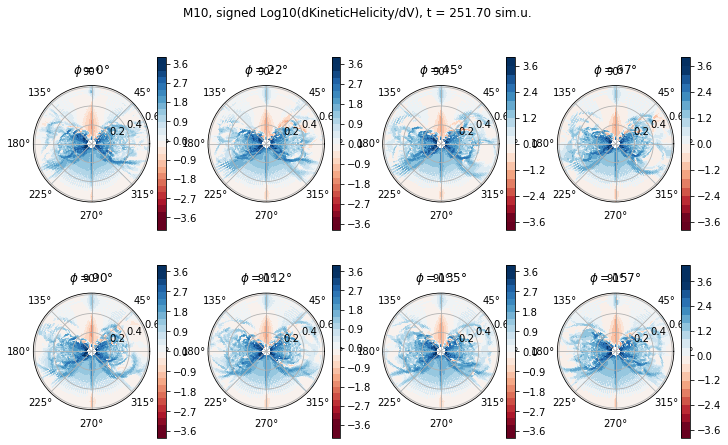

Plotting completed.


In [5]:
# Kinetic helicity for a snapshot

print("Calculating a snapshot of kinetic helicity...", flush=True)

time, ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV = kineticHelicity(snapshot_paths['None'])

print('done.', flush=True)

print('Plotting..', flush=True)

fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(2,4)
plt.suptitle('M%i, signed Log10(dKineticHelicity/dV), t = %.2f sim.u.' % (mach_no, time))

phis = np.linspace(0., np.pi, 9)
for i in range(8):

    phi0 = phis[i]
    phi0idx = min(np.where(pavg > phi0)[0])
    phi0idx2 = np.mod(phi0idx + int(0.5*len(pavg)), len(pavg))
    
    print(' - phi = %ideg' % (phi0*180./np.pi), flush=True)

    spl = plt.subplot(gs[int(i/4),i%4],projection='polar')
    plt.contourf(0.5*np.pi-tavgm[:,:,phi0idx], ravgm[:,:,phi0idx], helicity_dV[:,:,phi0idx], 25, cmap='RdBu', vmin=-3.5, vmax=3.5)
    plt.contourf(0.5*np.pi+tavgm[:,:,phi0idx2], ravgm[:,:,phi0idx2], helicity_dV[:,:,phi0idx2], 25, cmap='RdBu', vmin=-3.5, vmax=3.5)
    plt.colorbar()
    plt.ylim(0., None)
    plt.xlim(0., 2.*np.pi)
    plt.title('$\\phi=%i\\degree$' % (phi0*180./np.pi))

if save:
    plt.savefig('M%i_KinHelicity_snapshot.png' % mach_no, format='png', dpi=300)
else:
    plt.show()
plt.close()

print('Plotting completed.', flush=True)

In [5]:
# Time-averaged kinetic helicity, total helicity vs time

calc_avg = True

import os
from glob import glob
import pickle as pkl

print("Calculating time-averaged kinetic helicity...", flush=True)

# prepare and load previous data if applicable
athdf_files = sorted(glob(dataset_pathstem + 'R?/*.athdf'))
outfile = dataset_pathstem + 'KinHelicity_vs_t.pkl'
if not calc_avg and os.path.exists(outfile):
    with open(outfile, 'rb') as f:
        total_helicities = pkl.load(f)
        times = np.array(total_helicities).transpose()[0]
else:
    total_helicities = []
    times = []

if calc_avg:
    navg = 0; helicity_dV_avg = []
for athdf_file in athdf_files:
    # read from file
    print(athdf_file)
    data = athdf(athdf_file, quantities=[])
    if data['Time'] in times:
        print(' -- File already processed. Continue called.', flush=True)
        continue
    time, ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV, dV = kineticHelicity(athdf_file, logscale=False)
    # update averages
    if calc_avg:
        if len(helicity_dV_avg) > 0:
            helicity_dV_avg += helicity_dV
        else:
            helicity_dV_avg = 1. * helicity_dV
        navg += 1
    # calculate and save total helicity
    total_helicities.append([time, np.sum(helicity_dV * dV)])
    times.append(time)
    with open(outfile, 'wb') as f:
        pkl.dump(total_helicities, f)
    # clean up
    del helicity_dV
if calc_avg:
    helicity_dV_avg /= navg

print('done.', flush=True)

Calculating time-averaged kinetic helicity...
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00610.athdf
 -- t = 183.00 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00611.athdf
 -- t = 183.30 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00612.athdf
 -- t = 183.60 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00613.athdf
 -- t = 183.90 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00614.athdf
 -- t = 184.20 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/g

/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00655.athdf
 -- t = 196.50 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00656.athdf
 -- t = 196.80 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00657.athdf
 -- t = 197.10 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00658.athdf
 -- t = 197.40 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00659.athdf
 -- t = 197.70 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_low

/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00701.athdf
 -- t = 210.30 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00702.athdf
 -- t = 210.60 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00703.athdf
 -- t = 210.90 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00704.athdf
 -- t = 211.20 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00705.athdf
 -- t = 211.50 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_low

/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00746.athdf
 -- t = 223.80 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00747.athdf
 -- t = 224.10 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00748.athdf
 -- t = 224.40 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00749.athdf
 -- t = 224.70 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00750.athdf
 -- t = 225.00 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_low

/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00792.athdf
 -- t = 237.60 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00793.athdf
 -- t = 237.90 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00794.athdf
 -- t = 238.00 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00795.athdf
 -- File already processed. Continue called.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00796.athdf
 -- t = 238.80 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-m

 -- t = 250.80 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00837.athdf
 -- t = 251.10 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00838.athdf
 -- t = 251.40 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00839.athdf
 -- t = 251.70 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00840.athdf
 -- t = 252.00 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00841.athdf
 -- t = 252.30 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mh

/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00882.athdf
 -- t = 264.60 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00883.athdf
 -- t = 264.90 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00884.athdf
 -- t = 265.20 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00885.athdf
 -- t = 265.50 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00886.athdf
 -- t = 265.80 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_low

/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00928.athdf
 -- t = 278.40 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00929.athdf
 -- t = 278.70 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00930.athdf
 -- t = 279.00 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00931.athdf
 -- t = 279.30 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/R5/mhdLoops_strat.out2.00932.athdf
 -- t = 279.60 sim.u.
/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_low

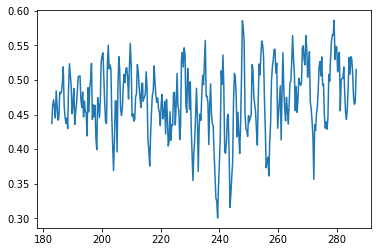

In [6]:
# plot time series of helicity
outfile = dataset_pathstem + 'KinHelicity_vs_t.pkl'
with open(outfile, 'rb') as f:
    total_helicities = pkl.load(f)
total_helicities = np.array(total_helicities).transpose()

plt.plot(total_helicities[0], total_helicities[1])
plt.show()
plt.close()

In [7]:
import pickle as pkl

with open('%sM%i_KinHelicity_avg.pkl' % (dataset_pathstem, mach_no), 'wb') as f:
    pkl.dump((ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV_avg, dV), f)

In [8]:
import pickle as pkl

with open('%sM%i_KinHelicity_avg.pkl' % (dataset_pathstem, mach_no), 'rb') as f:
    ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV_avg, dV = pkl.load(f)

Plotting..


/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


 - phi = 0deg
 - phi = 22deg
 - phi = 45deg
 - phi = 67deg
 - phi = 90deg
 - phi = 112deg
 - phi = 135deg
 - phi = 157deg


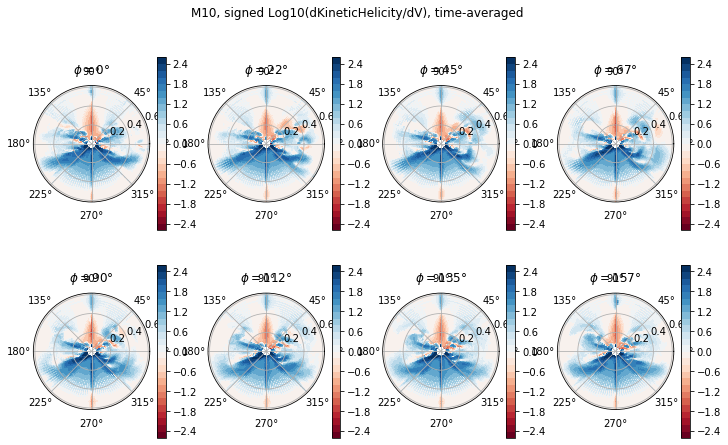

Plotting completed.


In [9]:
print('Plotting..', flush=True)

vborder = 2.5

fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(2,4)
plt.suptitle('M%i, signed Log10(dKineticHelicity/dV), time-averaged' % (mach_no,))

# turn into signed logscale
helicity_dV_avg = signed_logscale(helicity_dV_avg)
helicity_dV_avg = prune(helicity_dV_avg, -vborder, vborder, vborder)

phis = np.linspace(0., np.pi, 9)
for i in range(8):

    phi0 = phis[i]
    phi0idx = min(np.where(pavg > phi0)[0])
    phi0idx2 = np.mod(phi0idx + int(0.5*len(pavg)), len(pavg))
    
    print(' - phi = %ideg' % (phi0*180./np.pi), flush=True)

    spl = plt.subplot(gs[int(i/4),i%4],projection='polar')
    plt.contourf(0.5*np.pi-tavgm[:,:,phi0idx], ravgm[:,:,phi0idx], helicity_dV_avg[:,:,phi0idx], 25, cmap='RdBu', vmin=-vborder, vmax=vborder)
    plt.contourf(0.5*np.pi+tavgm[:,:,phi0idx2], ravgm[:,:,phi0idx2], helicity_dV_avg[:,:,phi0idx2], 25, cmap='RdBu', vmin=-vborder, vmax=vborder)
    plt.colorbar()
    plt.ylim(0., None)
    plt.xlim(0., 2.*np.pi)
    plt.title('$\\phi=%i\\degree$' % (phi0*180./np.pi))

if save:
    plt.savefig('M%i_KinHelicity_avg.png' % mach_no, format='png', dpi=300)
else:
    plt.show()
plt.close()

print('Plotting completed.', flush=True)

In [5]:
import pickle as pkl

with open('%sM%i_KinHelicity_avg.pkl' % (dataset_pathstem, mach_no), 'rb') as f:
    ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV_avg, dV = pkl.load(f)

Averaging azimuthally..
 -- total disk helicity for rho > 0.015000: 8.56e-02
 -- mean disk helicity for rho > 0.015000: 1.76e+00
done.
Plotting..


/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


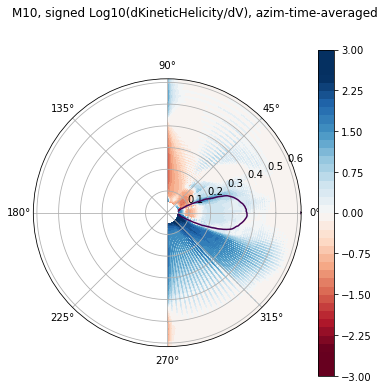

Plotting completed.


In [6]:
# plot azimuthally- and time-averaged data

print('Averaging azimuthally..', flush=True)

helicity_dV_avg_azim = np.mean(helicity_dV_avg, axis=2)

# calculate a rho contour
data = athdf(snapshot_paths['None'])
rhoavg = convolve(data['rho'], np.ones([2,2,2]) * (0.5**3), mode='constant', cval=np.nan)[:-1,:-1,:-1]
rhoavg = np.transpose(rhoavg, [2,1,0])
rhoavg = np.mean(rhoavg, axis=2)

# total helicity within it
rhomin = 0.015
dVsum = np.sum(dV, axis=2)
total_disk_helicity = np.sum(np.where(rhoavg > rhomin, helicity_dV_avg_azim * dVsum, 0.))
disk_volume = np.sum(np.where(rhoavg > rhomin, dVsum, 0.))
print(" -- total disk helicity for rho > %f: %.2e" % (rhomin, total_disk_helicity))
print(" -- mean disk helicity for rho > %f: %.2e" % (rhomin, total_disk_helicity / disk_volume))

# turn into signed logscale
helicity_dV_avg_azim = signed_logscale(helicity_dV_avg_azim)

print('done.', flush=True)

print('Plotting..', flush=True)

fig = plt.figure(figsize=(6,6))
plt.suptitle('M%i, signed Log10(dKineticHelicity/dV), azim-time-averaged' % (mach_no,))

spl = plt.subplot(111,projection='polar')
plt.contourf(0.5*np.pi-tavgm[:,:,0], ravgm[:,:,0], helicity_dV_avg_azim, 50, cmap='RdBu', vmin=-2.5, vmax=2.5)
plt.colorbar()
plt.ylim(0., None)
plt.xlim(0., 2.*np.pi)

# overplot a density contour
plt.contour(0.5*np.pi-tavgm[:,:,0], ravgm[:,:,0], rhoavg, [rhomin,])

if save:
    plt.savefig('M%i_KinHelicity_avg_azim.png' % mach_no, format='png', dpi=300)
else:
    plt.show()
plt.close()

print('Plotting completed.', flush=True)

In [17]:
import pickle as pkl

with open('%sM%i_KinHelicity_avg.pkl' % (dataset_pathstem, mach_no), 'rb') as f:
    ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV_avg, dV = pkl.load(f)

/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


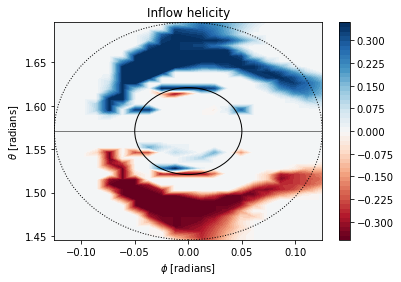

In [22]:
vborder = 0.35
angsize = 0.125

val = prune(signed_logscale(helicity_dV_avg), -vborder, vborder, vborder)
pavgm = np.where(pavgm < np.pi, pavgm, pavgm-2.*np.pi)
plt.tricontourf(pavgm[-1,:,:].flatten(), tavgm[-1,:,:].flatten(), val[-1,:,:].flatten(), 50, cmap='RdBu', vmin=-vborder, vmax=vborder)
#plt.contourf(pavgm[-1,:,:]-2.*np.pi, tavgm[-1,:,:], val[-1,:,:], 50, cmap='RdBu', vmin=-vborder, vmax=vborder)
plt.colorbar()
#plt.scatter(pavgm[-1,:,:].flatten(), tavgm[-1,:,:].flatten(), color='k', s=0.1)
inflow_circle = plt.Circle((0.0,0.5*np.pi), 0.05, fill=False, color='k')
plt.gca().add_artist(inflow_circle)
circle2 = plt.Circle((0.0,0.5*np.pi), angsize, fill=False, color='k', ls=':')
plt.gca().add_artist(circle2)

plt.axhline(0.5*np.pi, color='k', lw=0.5)

plt.xlim([-angsize, angsize])
plt.ylim([0.5*np.pi-angsize, 0.5*np.pi+angsize])

plt.xlabel('$\\phi$ [radians]')
plt.ylabel('$\\theta$ [radians]')
plt.title('Inflow helicity')

if save:
    plt.savefig('M%i_Hkin-inflow_rev1.png' % mach_no, format='png')
else:
    plt.show()
plt.close()

In [23]:

ang = angsize
helicity = np.where(tavgm[-1,:,:]**2 + pavgm[-1,:,:]**2 < ang**2, helicity_dV_avg[-1,:,:], 0)
r = np.unique(ravgm[-1,:,:])[0]
surface = np.pi * r**2 * ang**2
flux = np.mean(helicity) * surface * 0.5
print('Mean inflow kinetic helicity within %f rad: %.2e, flux: %.2e' % (angsize, np.mean(helicity), flux))

ang = 0.05
helicity = np.where(tavgm[-1,:,:]**2 + pavgm[-1,:,:]**2 < ang**2, helicity_dV_avg[-1,:,:], 0)
r = np.unique(ravgm[-1,:,:])[0]
surface = np.pi * r**2 * ang**2
flux = np.mean(helicity) * surface * 0.5
print('Mean inflow kinetic helicity within %f rad: %.2e, flux: %.2e' % (angsize, np.mean(helicity), flux))

Mean inflow kinetic helicity within 0.125000 rad: 2.59e-03, flux: 2.42e-05
Mean inflow kinetic helicity within 0.125000 rad: 6.43e-04, flux: 9.59e-07


In [12]:
tavgm.flatten()[np.argmin(np.abs(tavgm - 0.5*np.pi))]-0.5*np.pi

4.3711249286815246e-08

In [8]:
# plots for the review

fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,3, width_ratios=[1.5,1.25,1.5])

vborder = 2.5
rhomin = 0.015

#-------------------------
# time-averaged slice

# load
with open('%sM%i_KinHelicity_avg.pkl' % (dataset_pathstem, mach_no), 'rb') as f:
    ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV_avg, dV = pkl.load(f)

# turn into signed logscale
helicity_dV_avg = signed_logscale(helicity_dV_avg)
helicity_dV_avg = prune(helicity_dV_avg, -vborder, vborder, vborder)

phi0 = 0.
phi0idx = min(np.where(pavg > phi0)[0])
phi0idx2 = np.mod(phi0idx + int(0.5*len(pavg)), len(pavg))

spl = plt.subplot(gs[0,0],projection='polar')
plt.contourf(0.5*np.pi-tavgm[:,:,phi0idx], ravgm[:,:,phi0idx], helicity_dV_avg[:,:,phi0idx], 50, cmap='RdBu', vmin=-vborder, vmax=vborder)
plt.contourf(0.5*np.pi+tavgm[:,:,phi0idx2], ravgm[:,:,phi0idx2], helicity_dV_avg[:,:,phi0idx2], 50, cmap='RdBu', vmin=-vborder, vmax=vborder)
plt.colorbar()
plt.ylim(0., None)
plt.xlim(0., 2.*np.pi)
plt.title('$\\phi=%i,180\\degree$, time-avg' % (phi0*180./np.pi))

plt.gca().xaxis.set_ticklabels([])
plt.gca().set_yticks([0.2,0.4,0.6])

del ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV_avg, dV

#------------------------------------------
# time- and azimuthally averaged profile

# load
with open('%sM%i_KinHelicity_avg.pkl' % (dataset_pathstem, mach_no), 'rb') as f:
    ravg, tavg, pavg, ravgm, tavgm, pavgm, helicity_dV_avg, dV = pkl.load(f)
    
# average
helicity_dV_avg_azim = np.mean(helicity_dV_avg, axis=2)

# calculate a rho contour
data = athdf(snapshot_path)
rhoavg = convolve(data['rho'], np.ones([2,2,2]) * (0.5**3), mode='constant', cval=np.nan)[:-1,:-1,:-1]
rhoavg = np.transpose(rhoavg, [2,1,0])
rhoavg = np.mean(rhoavg, axis=2)

# turn into signed logscale
helicity_dV_avg_azim = signed_logscale(helicity_dV_avg_azim)

spl = plt.subplot(gs[0,1],projection='polar')
plt.contourf(0.5*np.pi-tavgm[:,:,0], ravgm[:,:,0], helicity_dV_avg_azim, 50, cmap='RdBu', vmin=-vborder, vmax=vborder)
#plt.colorbar()
plt.ylim(0., None)
plt.xlim(0., 2.*np.pi)

# overplot a density contour
plt.contour(0.5*np.pi-tavgm[:,:,0], ravgm[:,:,0], rhoavg, [rhomin,])

# label
plt.title('$\\phi$ and time avg')
plt.gca().xaxis.set_ticklabels([])
plt.gca().set_yticks([0.2,0.4,0.6])

del tavg, pavg, ravgm, tavgm, pavgm, helicity_dV_avg, dV

#------------------------------------------
# evolution with time

plt.subplot(gs[0,2])

# prepare and load previous data if applicable
outfile = dataset_pathstem + 'KinHelicity_vs_t.pkl'
with open(outfile, 'rb') as f:
    total_helicities = pkl.load(f)
total_helicities = np.array(total_helicities).transpose()

# turn into volume-average
total_helicities[1] /= (4./3.)*np.pi*(max(ravg)**3 - min(ravg)**3)

plt.plot((total_helicities[0] - tstart_steady)/Porb, total_helicities[1])

# fit a slope
from sklearn.linear_model import LinearRegression
x = (total_helicities[0] - tstart_steady)/Porb
reg = LinearRegression().fit(x.reshape([-1,1]), total_helicities[1].reshape([-1,1]))
a = reg.coef_[0]
b = reg.intercept_
print('Linear regression a=%.2e, b=%.2e' % (a,b))
plt.plot(x, a*x+b, 'k-', label=('%.2e (x+20) + %.2e' % (a,b-20.*a)))

# label
plt.xlim(0., None)
plt.xlabel('Time [$P_{\\rm orb}$]')
plt.ylabel('Mean $H_{\\rm kin}$ density')
plt.grid(True)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
plt.legend()

#------------------------------------------
# show / save

if True:# save:
    plt.savefig('M%i_Hkin_rev1.png' % mach_no, format='png')
else:
    plt.show()
plt.close()

/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


Linear regression a=1.56e-03, b=4.75e-01
